### 1. 데이터 불러오기 및 전처리

In [1]:
# 수집된 데이터 불러오기
import pandas as pd

df1 = pd.read_csv("../data/review-rating1.csv")
df2 = pd.read_csv("../data/review-rating2.csv")
df3 = pd.read_csv("../data/review-rating3.csv")
df4 = pd.read_csv("../data/review-rating4.csv")

df = pd.concat([df1, df2, df3, df4])
df.head()

,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 100% 성공이다. 원래 한국영화들 속편은 잘 안되고 속편 나오면...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요. 유머도 내 스타일이라...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요. 나쁜놈들 잡는 캐릭터로...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 1편도 2편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 ...,0,범죄도시2,8.99


In [2]:
# 인덱스 재설정
df.reset_index(drop=True, inplace=True)
df.head()

,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 100% 성공이다. 원래 한국영화들 속편은 잘 안되고 속편 나오면...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요. 유머도 내 스타일이라...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요. 나쁜놈들 잡는 캐릭터로...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 1편도 2편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 ...,0,범죄도시2,8.99


In [3]:
# 데이터 크기 확인
len(df)

1183849

In [4]:
# 중복되지 않은 데이터 확인
df['리뷰'].nunique(), df['실제평점'].nunique()


(1060077, 10)

In [5]:
df.duplicated().sum()

45854

In [6]:
# 중복값 제거
df.drop_duplicates(inplace=True)
len(df)

1137995

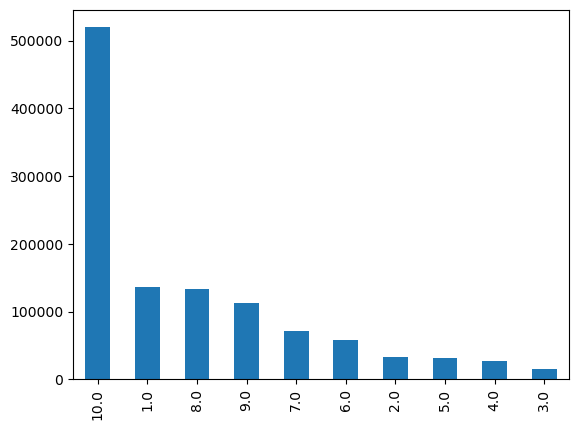

In [7]:
# 평점 분포 그래프
import matplotlib.pyplot as plt
df['실제평점'].value_counts().plot(kind = 'bar')
plt.show()

In [8]:
# 특수문자,기호 제거
df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df[:5]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5056\2647383859.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 성공이다 원래 한국영화들 속편은 잘 안되고 속편 나오면 망하는 ...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요 유머도 내 스타일이라 ...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요 나쁜놈들 잡는 캐릭터로는...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 편도 편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 진짜...,0,범죄도시2,8.99


In [9]:
# 공백 제거
import numpy as np

df['리뷰'] = df['리뷰'].str.replace('^ +', "")
df['리뷰'].replace('', np.nan, inplace=True)
df.isnull().sum()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5056\4057912268.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['리뷰'] = df['리뷰'].str.replace('^ +', "")


실제평점       0
리뷰      6145
영화ID       0
영화명        0
평균평점       0
dtype: int64

In [10]:
df.loc[df['리뷰'].isnull()][:5]

,실제평점,리뷰,영화ID,영화명,평균평점
565,10.0,NaN,1,아바타: 물의 길,8.82
707,10.0,NaN,2,탑건: 매버릭,9.60
743,10.0,NaN,2,탑건: 매버릭,9.60
786,8.0,NaN,2,탑건: 매버릭,9.60
909,10.0,NaN,2,탑건: 매버릭,9.60


In [11]:
# null 샘플 제거
df = df.dropna(how = 'any')
len(df)

1131850

In [12]:
# 불용어 사전
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [29]:
# 독립변수 X, 종속변수 y, 종속변수 원핫인코딩
X = df['리뷰']
# y = pd.get_dummies(df['실제평점'])
y = df['실제평점']

In [24]:
y[1.0].sum() # 134861
y[2.0].sum() # 32879
y[3.0].sum() # 15301
y[4.0].sum() # 26513
y[5.0].sum() # 31685
y[6.0].sum() # 57948
y[7.0].sum() # 70704
y[8.0].sum() # 132693
y[9.0].sum() # 112258
y[10.0].sum() # 517008

517008

In [ ]:
# 종속변수 실수 변환
y = y.astype('float64')

In [30]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

rus = RandomUnderSampler(sampling_strategy={1.0 : 134861,
                                            2.0 : 32879,
                                            3.0 : 15301,
                                            4.0 : 26513,
                                            5.0 : 31685,
                                            6.0 : 57948,
                                            7.0 : 70704,
                                            8.0 : 132693,
                                            9.0 : 112258,
                                            10.0 : 152258})

X_reshaped = X.values.reshape(-1, 1)  # X를 2차원으로 변환

X, y = rus.fit_resample(X_reshaped, y)

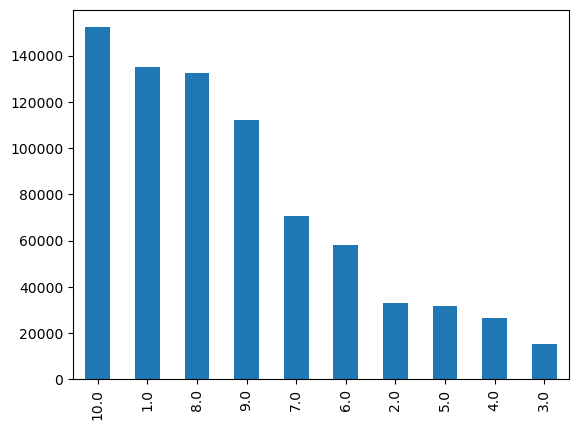

In [31]:
# 평점 분포 재확인
import matplotlib.pyplot as plt

y.value_counts().plot(kind = 'bar')
plt.show()

In [34]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()
X_lis = []

# 형태소 분석
for sentence in tqdm(X):
    sentence_str = str(sentence)  # NumPy 배열을 문자열로 변환
    temp_X = okt.morphs(sentence_str, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]
    X_lis.append(temp_X)

100%|██████████| 767100/767100 [3:57:10<00:00, 53.91it/s]   


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_lis)
print(tokenizer.word_index)

{"['": 1, "']": 2, '이': 3, '영화': 4, '하다': 5, '보다': 6, '의': 7, '에': 8, '가': 9, '을': 10, '들': 11, '도': 12, '를': 13, '은': 14, '는': 15, '있다': 16, '좋다': 17, '없다': 18, '이다': 19, '너무': 20, '한': 21, '되다': 22, '적': 23, '같다': 24, '으로': 25, '만': 26, '않다': 27, '과': 28, '다': 29, '연기': 30, '로': 31, '아니다': 32, '것': 33, '에서': 34, '재밌다': 35, '생각': 36, '그': 37, '스토리': 38, '진짜': 39, '인': 40, '나오다': 41, '배우': 42, '정말': 43, '사람': 44, '만들다': 45, '와': 46, '더': 47, '자다': 48, '안': 49, '나': 50, '수': 51, '점': 52, '못': 53, '내': 54, '게': 55, '고': 56, '볼': 57, '그냥': 58, '보고': 59, '하고': 60, '가다': 61, '평점': 62, '좀': 63, '시간': 64, '감독': 65, '감동': 66, '요': 67, '왜': 68, '내용': 69, '말': 70, '사랑': 71, '싶다': 72, '재미있다': 73, '까지': 74, '때': 75, '들다': 76, '그렇다': 77, '모르다': 78, '지루하다': 79, '이렇다': 80, '많다': 81, '느낌': 82, '아깝다': 83, '잘': 84, '이야기': 85, '마지막': 86, '재미': 87, '주다': 88, '연출': 89, '오다': 90, '장면': 91, '액션': 92, '거': 93, '알다': 94, '네': 95, 'ㅋㅋ': 96, '아이': 97, '아쉽다': 98, '최고': 99, '주인공': 100, '돈': 101, '저': 102, '정도': 10

In [36]:
# 출현빈도가 2회 미만인 단어들
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print(total_cnt) # 단어집합 크기
print(rare_cnt) # 희귀단어수

# total_cnt = 87256 단어집합 크기
# rare_cnt = 35688 희귀단어수

87256
35688


In [37]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

# vocab_size = 51569

단어 집합의 크기 : 51569


In [38]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_lis) # 텍스트를 숫자 시퀀스로 변환
X = tokenizer.texts_to_sequences(X_lis)

In [39]:
print(X[:3])

[[1, 362, 15, 494, 446, 117, 700, 508, 4761, 24, 4, 95, 2], [1, 1546, 7, 82, 3, 68, 52, 32, 52, 1130, 2], [1, 217, 111, 8, 892, 2]]


In [40]:
# 종속변수 원핫인코딩

y = pd.get_dummies(y)

In [41]:
# 학습용 8, 검증용 2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [42]:
# 종속변수 저장
import numpy as np

np.save('../data/y_train_rus.npy', y_train)
np.save('../data/y_test_rus.npy', y_test)

In [1]:
# 종속변수 불러오기
import numpy as np

y_train = np.load('../data/y_train_rus.npy')
y_test = np.load('../data/y_test_rus.npy')

In [43]:
# 독립변수 저장
import csv
with open('../data/X_test_rus.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_test)

with open('../data/X_train_rus.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_train)

In [2]:
# 독립변수 불러오기
import csv

X_train = []
with open('../data/X_train_rus.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        for row2 in row:
            row3 = [float(num) for num in row2.strip('[]').split(',') if num.strip()]
            X_train.append(row3)

X_test = []
with open('../data/X_test_rus.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        for row2 in row:
            row3 = [float(num) for num in row2.strip('[]').split(',') if num.strip()]
            X_test.append(row3)

In [3]:
max_len = max(len(l) for l in X_train) # 리뷰의 최대 길이
max_len
# max_len = 217

217

In [4]:
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
# 최대 길이 이하인 샘플의 비율
(cnt / len(X_train))*100

# 83.52838612957893

83.52838612957893

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [47]:
# 기본 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D

def build_model1(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 1024, input_length=max_len))
    model.add(Conv1D(filters=512, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model1 = build_model1(vocab_size, max_len, num_classes)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 217, 1024)         52806656  
                                                                 
 conv1d (Conv1D)             (None, 217, 512)          2621952   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 512)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 22016)             0         
                                                                 
 dense (Dense)               (None, 10)                220170    
                                                                 
Total params: 55,648,778
Trainable params: 55,648,778
Non-trainable params: 0
____________________________________________

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 훈련을 위한 콜백 설정
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../review_CNN_origin_cp.h5', save_best_only=True)

In [49]:
# 모델 훈련
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
7671/7671 [==============================] - 1487s 193ms/step - loss: 1.7027 - accuracy: 0.3761 - val_loss: 1.6776 - val_accuracy: 0.3808
Epoch 2/10
7671/7671 [==============================] - 1473s 192ms/step - loss: 1.5798 - accuracy: 0.4167 - val_loss: 1.6971 - val_accuracy: 0.3863
Epoch 3/10
7671/7671 [==============================] - 1472s 192ms/step - loss: 1.4390 - accuracy: 0.4681 - val_loss: 1.8042 - val_accuracy: 0.3790
Epoch 4/10
7671/7671 [==============================] - 1472s 192ms/step - loss: 1.2711 - accuracy: 0.5323 - val_loss: 2.0048 - val_accuracy: 0.3689


In [50]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model1.history.history['loss']
val_loss = model1.history.history['val_loss']
train_acc = model1.history.history['accuracy']
val_acc = model1.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

# 언더샘플링 전
# 1.4868658781051636
# 0.5136653780937195
# 1.4559547901153564
# 0.5209612846374512

1.7027440071105957
0.3760836124420166
1.677606225013733
0.38076847791671753


In [51]:
# 모델 평가
model1.evaluate(X_test, y_test)

# 언더샘플링 전
# [1.4600964784622192, 0.5203251242637634]

4795/4795 [==============================] - 83s 17ms/step - loss: 1.6757 - accuracy: 0.3805


[1.6756712198257446, 0.3805044889450073]

In [52]:
pred1 = model1.predict(X_test)

4795/4795 [==============================] - 76s 16ms/step


In [53]:
pred1_binary = np.where(pred1 <= 0.5, 0, 1)

In [54]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred1_binary)
print(report)

# 언더샘플링 전
#                   precision    recall  f1-score   support

#            0       0.66      0.41      0.51     26972
#            1       1.00      0.00      0.00      6576
#            2       0.00      0.00      0.00      3060
#            3       0.50      0.00      0.00      5302
#            4       0.18      0.00      0.00      6337
#            5       0.26      0.00      0.00     11590
#            6       0.33      0.00      0.00     14141
#            7       0.31      0.00      0.00     26539
#            8       0.33      0.00      0.00     22452
#            9       0.71      0.60      0.65    103401

#    micro avg       0.70      0.32      0.44    226370
#    macro avg       0.43      0.10      0.12    226370
# weighted avg       0.55      0.32      0.36    226370
#  samples avg       0.32      0.32      0.32    226370

              precision    recall  f1-score   support

           0       0.72      0.46      0.56     26972
           1       0.24      0.00      0.00      6576
           2       0.50      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.23      0.00      0.00      6337
           5       0.30      0.01      0.01     11590
           6       0.37      0.00      0.01     14141
           7       0.34      0.00      0.00     26538
           8       0.33      0.03      0.05     22452
           9       0.64      0.29      0.40     30452

   micro avg       0.66      0.14      0.24    153420
   macro avg       0.37      0.08      0.10    153420
weighted avg       0.45      0.14      0.19    153420
 samples avg       0.14      0.14      0.14    153420



c:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# 모델 저장
model1.save('../model/review_CNN_1.h5')

In [7]:
# 합성곱 레이어 추가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout

def build_model2(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 1024, input_length=max_len))
    model.add(Conv1D(filters=512, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model2 = build_model2(vocab_size, max_len, num_classes)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 217, 1024)         55554048  
                                                                 
 conv1d (Conv1D)             (None, 217, 512)          2621952   
                                                                 
 conv1d_1 (Conv1D)           (None, 217, 256)          655616    
                                                                 
 conv1d_2 (Conv1D)           (None, 217, 128)          163968    
                                                                 
 conv1d_3 (Conv1D)           (None, 217, 64)           41024     
                                                                 
 conv1d_4 (Conv1D)           (None, 217, 32)           10272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 32)           0

In [9]:
# 모델 훈련
model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
7671/7671 [==============================] - 1919s 249ms/step - loss: 1.7333 - accuracy: 0.3655 - val_loss: 1.6553 - val_accuracy: 0.3899
Epoch 2/20
7671/7671 [==============================] - 1905s 248ms/step - loss: 1.6250 - accuracy: 0.4003 - val_loss: 1.6490 - val_accuracy: 0.3928
Epoch 3/20
7671/7671 [==============================] - 1900s 248ms/step - loss: 1.5697 - accuracy: 0.4160 - val_loss: 1.6649 - val_accuracy: 0.3912
Epoch 4/20
7671/7671 [==============================] - 1912s 249ms/step - loss: 1.5173 - accuracy: 0.4324 - val_loss: 1.6774 - val_accuracy: 0.3903
Epoch 5/20
7671/7671 [==============================] - 1916s 250ms/step - loss: 1.4581 - accuracy: 0.4522 - val_loss: 1.7274 - val_accuracy: 0.3860


In [10]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model2.history.history['loss']
val_loss = model2.history.history['val_loss']
train_acc = model2.history.history['accuracy']
val_acc = model2.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

# 언더샘플링 전
# 1.458750605583191
# 0.5227199792861938
# 1.3813133239746094
# 0.5381068587303162

1.7332950830459595
0.3654530942440033
1.6553164720535278
0.3898937702178955


In [11]:
# 모델 평가
model2.evaluate(X_test, y_test)

# 언더샘플링 전
# [1.3697010278701782, 0.5426248908042908]

4795/4795 [==============================] - 116s 24ms/step - loss: 1.6460 - accuracy: 0.3923


[1.6460124254226685, 0.39231520891189575]

In [12]:
pred2 = model2.predict(X_test)

4795/4795 [==============================] - 109s 23ms/step


In [13]:
pred2_binary = np.where(pred2 <= 0.5, 0, 1)

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred2_binary)
print(report)

# 언더샘플링 전
#                 precision    recall  f1-score   support

#            0       0.69      0.48      0.56     26972
#            1       0.00      0.00      0.00      6576
#            2       0.00      0.00      0.00      3060
#            3       0.00      0.00      0.00      5302
#            4       0.00      0.00      0.00      6337
#            5       0.00      0.00      0.00     11590
#            6       0.00      0.00      0.00     14141
#            7       0.00      0.00      0.00     26539
#            8       0.00      0.00      0.00     22452
#            9       0.68      0.79      0.73    103401

#    micro avg       0.69      0.42      0.52    226370
#    macro avg       0.14      0.13      0.13    226370
# weighted avg       0.40      0.42      0.40    226370
#  samples avg       0.42      0.42      0.42    226370

              precision    recall  f1-score   support

           0       0.68      0.58      0.62     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.33      0.00      0.00     14141
           7       0.00      0.00      0.00     26538
           8       0.27      0.00      0.00     22452
           9       0.66      0.27      0.38     30452

   micro avg       0.67      0.15      0.25    153420
   macro avg       0.19      0.08      0.10    153420
weighted avg       0.32      0.15      0.18    153420
 samples avg       0.15      0.15      0.15    153420



c:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 모델 저장
model2.save('../model/review_CNN_2.h5')

In [16]:
# 커널사이즈 감소, 맥스풀링 증가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 51569

def build_model3(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 1024, input_length=max_len))
    model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(10))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model3 = build_model3(vocab_size, max_len, num_classes)
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 217, 1024)         52806656  
                                                                 
 conv1d_5 (Conv1D)           (None, 217, 512)          1573376   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 512)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10752)             0         
                                                                 
 dropout_1 (Dropout)         (None, 10752)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                107530    
                                                      

In [17]:
# 모델 훈련
model3.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
7671/7671 [==============================] - 1316s 171ms/step - loss: 1.9005 - accuracy: 0.3040 - val_loss: 1.8597 - val_accuracy: 0.3162
Epoch 2/20
7671/7671 [==============================] - 1314s 171ms/step - loss: 1.8478 - accuracy: 0.3259 - val_loss: 1.8543 - val_accuracy: 0.3211
Epoch 3/20
1798/7671 [======>.......................] - ETA: 16:08 - loss: 1.7822 - accuracy: 0.3469

KeyboardInterrupt: 

In [ ]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model3.history.history['loss']
val_loss = model3.history.history['val_loss']
train_acc = model3.history.history['accuracy']
val_acc = model3.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.494875431060791
0.5163987874984741
1.390289545059204
0.535020112991333


In [ ]:
# 모델 평가
model3.evaluate(X_test, y_test)

7075/7075 [==============================] - 31s 4ms/step - loss: 1.3771 - accuracy: 0.5406


[1.3771028518676758, 0.5405575037002563]

In [ ]:
pred3 = model3.predict(X_test)

7075/7075 [==============================] - 22s 3ms/step


In [ ]:
pred3_binary = np.where(pred3 <= 0.5, 0, 1)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred3_binary)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.54      0.59     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.83      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.72      0.70      0.71    103401

   micro avg       0.71      0.38      0.50    226370
   macro avg       0.22      0.12      0.13    226370
weighted avg       0.51      0.38      0.39    226370
 samples avg       0.38      0.38      0.38    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 모델 저장
model3.save('../model/review_CNN_3.h5')

In [ ]:
# 노이즈 추가, 맥스풀링 추가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

vocab_size = 51569

def build_model4(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 1024, input_length=max_len))
    model.add(Conv1D(filters=512, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

num_classes = 10
model4 = build_model5(vocab_size, max_len, num_classes)
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 384, 1024)         55554048  
                                                                 
 conv1d_18 (Conv1D)          (None, 384, 256)          1310976   
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 192, 256)         0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 192, 128)          163968    
                                                                 
 conv1d_20 (Conv1D)          (None, 192, 64)           41024     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 96, 64)           0         
 1D)                                                  

In [ ]:
# 노이즈
X_train_noise = X_train + np.random.normal(0, 0.01, size = X_train.shape)
y_train_noise = y_train + np.random.normal(0, 0.01, size = y_train.shape)

In [ ]:
# 모델 훈련
model4.fit(X_train_noise, y_train_noise, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 318s 27ms/step - loss: 1.5977 - accuracy: 0.5022 - val_loss: 1.5152 - val_accuracy: 0.5143
Epoch 2/10
11319/11319 [==============================] - 244s 22ms/step - loss: 1.4787 - accuracy: 0.5216 - val_loss: 1.4770 - val_accuracy: 0.5203
Epoch 3/10
11319/11319 [==============================] - 243s 21ms/step - loss: 1.4150 - accuracy: 0.5359 - val_loss: 1.4661 - val_accuracy: 0.5210
Epoch 4/10
11319/11319 [==============================] - 241s 21ms/step - loss: 1.3583 - accuracy: 0.5489 - val_loss: 1.4987 - val_accuracy: 0.5172
Epoch 5/10
11319/11319 [==============================] - 243s 21ms/step - loss: 1.3029 - accuracy: 0.5621 - val_loss: 1.5427 - val_accuracy: 0.5091
Epoch 6/10
11319/11319 [==============================] - 241s 21ms/step - loss: 1.2590 - accuracy: 0.5738 - val_loss: 1.6137 - val_accuracy: 0.4942


In [ ]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model4.history.history['loss']
val_loss = model4.history.history['val_loss']
train_acc = model4.history.history['accuracy']
val_acc = model4.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.5976982116699219
0.5022474527359009
1.5152140855789185
0.5142797231674194


In [ ]:
# 모델 평가
model4.evaluate(X_test, y_test)

7075/7075 [==============================] - 34s 5ms/step - loss: 1.4707 - accuracy: 0.5210


[1.4707094430923462, 0.5209921598434448]

In [ ]:
pred4 = model4.predict(X_test)

7075/7075 [==============================] - 24s 3ms/step


In [ ]:
pred4_binary = np.where(pred4 <= 0.5, 0, 1)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred4_binary)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      0.33      0.45     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.00      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.68      0.70      0.69    103401

   micro avg       0.68      0.36      0.47    226370
   macro avg       0.14      0.10      0.11    226370
weighted avg       0.40      0.36      0.37    226370
 samples avg       0.36      0.36      0.36    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 모델 저장
model4.save('../model/review_CNN_4.h5')

In [ ]:
# sparse categorical crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 54252

def build_model_sparse(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 1024, input_length=max_len))
    model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model_sparse = build_model_sparse(vocab_size, max_len, num_classes)
model_sparse.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 384, 128)          6944256   
                                                                 
 conv1d (Conv1D)             (None, 384, 256)          98560     
                                                                 
 conv1d_1 (Conv1D)           (None, 384, 128)          98432     
                                                                 
 conv1d_2 (Conv1D)           (None, 384, 64)           24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 384, 32)           6176      
                                                                 
 conv1d_4 (Conv1D)           (None, 384, 16)           1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 16)           0

In [ ]:
# 노이즈
X_train_noise = X_train + np.random.normal(0, 0.01, size = X_train.shape)
y_train_noise = y_train + np.random.normal(0, 0.01, size = y_train.shape)

In [ ]:
# 모델 훈련
model_sparse.fit(X_train_noise, y_train_noise, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 595s 52ms/step - loss: nan - accuracy: 2.7610e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
11319/11319 [==============================] - 592s 52ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
11319/11319 [==============================] - 591s 52ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [ ]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model_sparse.history.history['loss']
val_loss = model_sparse.history.history['val_loss']
train_acc = model_sparse.history.history['accuracy']
val_acc = model_sparse.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.494875431060791
0.5163987874984741
1.390289545059204
0.535020112991333


In [ ]:
# 모델 평가
model_sparse.evaluate(X_test, y_test)

7075/7075 [==============================] - 31s 4ms/step - loss: 1.3771 - accuracy: 0.5406


[1.3771028518676758, 0.5405575037002563]

In [ ]:
pred_sparse = model_sparse.predict(X_test)

7075/7075 [==============================] - 22s 3ms/step


In [ ]:
pred_sparse_binary = np.where(pred_sparse <= 0.5, 0, 1)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred6_binary)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.54      0.59     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.83      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.72      0.70      0.71    103401

   micro avg       0.71      0.38      0.50    226370
   macro avg       0.22      0.12      0.13    226370
weighted avg       0.51      0.38      0.39    226370
 samples avg       0.38      0.38      0.38    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 모델 저장
model_sparse.save('../model/review_CNN_sparse.h5')

In [2]:
# 모델 적용
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model('../model/review_CNN_1_undersampling.h5')

stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

okt = Okt()
sentence = input('')
max_len = len(sentence)
sentence_okt = okt.morphs(sentence, stem=True) # 토큰화
sentence_okt = [word for word in sentence_okt if not word in stopwords] # 불용어 제거
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence_okt)
sentence_token = tokenizer.texts_to_sequences(sentence_okt)
sentence_token = pad_sequences(sentence_token, maxlen=217)
sentence_token = [sentence_token]

pred = model.predict(sentence_token)
max_index = np.argmax(pred, axis=1)
predicted_rating = round(max_index.sum() / len(max_index)) + 1
print('리뷰내용:', sentence)
print('평점은:', predicted_rating)

1/1 [==============================] - 0s 148ms/step
리뷰내용: 이 영화 cg 빼곤 뭐 없네요. 재미없음..
평점은: 2
